# NLP-Spam or Not Spam

## Data Preprocessing

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = #'userid'
os.environ['KAGGLE_KEY'] = #'key'

In [2]:
!kaggle datasets download -d datatattle/email-classification-nlp

  0% 0.00/46.8k [00:00<?, ?B/s]
100% 46.8k/46.8k [00:00<00:00, 37.6MB/s]


In [3]:
!unzip -q email-classification-nlp.zip -d .

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('SMS_train.csv', encoding= 'unicode_escape')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        957 non-null    int64 
 1   Message_body  957 non-null    object
 2   Label         957 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [11]:
df.Label[df.Label == 'Spam'] = 1 
df.Label[df.Label == 'Non-Spam'] = 0
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,0
1,2,The guy did some bitching but I acted like i'd...,0
2,3,"Pity, * was in mood for that. So...any other s...",0
3,4,Will ü b going to esplanade fr home?,0
4,5,This is the 2nd time we have tried 2 contact u...,1


In [12]:
df = df.astype({'Label':float})
df.dtypes

S. No.            int64
Message_body     object
Label           float64
dtype: object

In [14]:
x = df['Message_body'].values
y = df['Label'].values

In [15]:
#split train test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [16]:
#tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)

In [17]:
#feature scaling
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)
 
padded_train = pad_sequences(sequence_train) 
padded_test = pad_sequences(sequence_test)

## Create Sequential Model using LSTM

In [18]:
import tensorflow as tf
#create model
nlp = tf.keras.Sequential([                       
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
#compile
nlp.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

## Train the Model

In [25]:
#callback function
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAccuracy has reached > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [26]:
history = nlp.fit(padded_train,
                  y_train,
                  epochs=50, 
                  validation_data=(padded_test, y_test),
                  verbose=2,
                  callbacks=[callbacks])

Epoch 1/50
24/24 - 1s - loss: 0.1720 - accuracy: 0.8641 - val_loss: 0.1220 - val_accuracy: 0.9062
Epoch 2/50
24/24 - 1s - loss: 0.1119 - accuracy: 0.8863 - val_loss: 0.0948 - val_accuracy: 0.9792
Epoch 3/50
24/24 - 1s - loss: 0.0935 - accuracy: 0.9974 - val_loss: 0.0967 - val_accuracy: 0.9844

Accuracy has reached > 90%!


## Plotting Loss and Accuracy

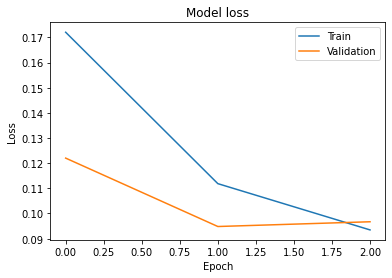

In [30]:
import matplotlib.pyplot as plt

#plot loss vs epochs
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

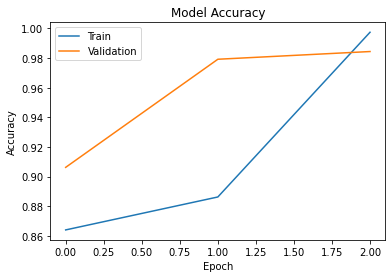

In [31]:
#plot accuracy vs epochs
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Conclusion

In [ ]:
#With simple datasets (<1000 sample and 2 label), using this model we can have accuracy > 90% with only 3 epochs